In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from geo_transform.tf_tps import ThinPlateSpline as tps

import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from functools import partial
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from dev_utils import tf_session
tf_session.setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


# 1.Data load

In [4]:
_datapath = "sample_dataset"
filelist = os.listdir(_datapath)
input_size = (200, 200)

images = []

for f in filelist:
    _path = os.path.join(_datapath, f)
    img = cv2.imread(_path)[:,:,::-1]
    img = cv2.resize(img, input_size, interpolation=cv2.INTER_AREA)
    images.append(img)

images = np.array(images, dtype=np.float32)

In [5]:
def pad_image(image, pad_ratio):
    '''
        input : original image, padding_ratio( ragne 0~1 )
        output : padded_image(reflected boundary)
    '''
    original_size = (image.shape[0], image.shape[1])
    top = bottom = int(original_size[0] * pad_ratio)
    left = right = int(original_size[1] * pad_ratio)
    padded_image = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_REFLECT)
    return padded_image

In [6]:
def py_image_process(image, motion_vectors, tps_random_rate, output_size):
    image = tf.keras.applications.vgg16.preprocess_input(image)
    image = image.numpy()
    tps_random_rate = tps_random_rate.numpy()
    #image = image / 255.
    padded_image = pad_image(image, tps_random_rate)
    
    ratio = 1/(1 + tps_random_rate)
    control_points = tf.constant([[-ratio, -ratio], [0.0, -ratio], [ratio, -ratio],
                               [-ratio, 0.0], [0.0, 0.0], [ratio, 0.0],
                               [-ratio, ratio], [0.0, ratio], [ratio, ratio]], dtype=tf.float32)
    x_s, y_s = tps(control_points[tf.newaxis,::], -motion_vectors[tf.newaxis,::], padded_image.shape[0:2])
    synth_image = cv2.remap(padded_image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC)
    dH = (synth_image.shape[0] - image.shape[0])/2
    dW = (synth_image.shape[1] - image.shape[1])/2
    dH, dW = int(dH), int(dW)
    synth_image = synth_image[dH:-dH, dW:-dW]    
    return image, synth_image, motion_vectors

In [7]:
def tf_image_process(image, tps_random_rate, output_size):
    motion_vectors = (tf.random.uniform([9, 2]) - 0.5) * 2 * tps_random_rate
    return tf.py_function(py_image_process, [image, motion_vectors, tps_random_rate, output_size], [tf.float32, tf.float32, tf.float32])

In [8]:
tps_random_rate = 0.4
output_size = (200, 200)
map_func = partial(tf_image_process, tps_random_rate=tps_random_rate,
                      output_size=output_size)

ds = tf.data.Dataset.from_tensor_slices(images)
ds = ds.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(16)

In [9]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    print(p.shape)

(10, 200, 200, 3) (10, 200, 200, 3)
(10, 9, 2)


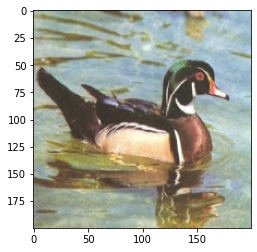

In [10]:
plt.imshow(images[1]/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


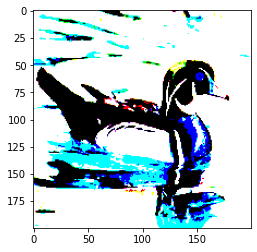

In [11]:
plt.imshow(A[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


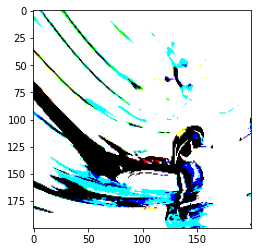

In [12]:
plt.imshow(B[1])

# 2. Model definition

In [13]:
# (a) feature extraction
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block4_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)

In [14]:
# (b) channel-wise l2 normalization
def feature_l2_normalization(feature_map):
    #input(feature map) has tensor-shape (N, H, W, D)
    l2_norm = tf.math.sqrt(tf.reduce_sum(tf.pow(feature_map, 2), axis=-1))  # (N, H, W)
    l2_norm = tf.expand_dims(l2_norm, axis=-1)  # (N, H, W, 1)
    # (N, H, W, D) tensor divided by (N, H, W, 1) tensor
    return feature_map / (l2_norm+1E-5)

In [15]:
# (c) Matching layer
class Correlation_network(tf.keras.layers.Layer):
    def __init__(self):
        super(Correlation_network, self).__init__()

    def call(self, feature_A, feature_B):
        # featureA : feature information from source image
        # featureB : feature information from target image
        #assert feature_A.shape == feature_B.shape
        # new feature A and feature B have new shape of tensors.
        # featureA has tensor shape as [batch, HA, WA, 1, 1, depth]
        # featureB has tensor shape as [batch, 1, 1, HB, WB, depth]
        feature_A = feature_A[:, :, :, tf.newaxis, tf.newaxis, :]
        feature_B = feature_B[:, tf.newaxis, tf.newaxis, :, :, :]
        # correlation score has tensor shape as [batch, HA, WA, HB, WB]
        corr_score = tf.reduce_sum(tf.multiply(feature_A, feature_B), axis=-1)
        return corr_score
# repeat penalty
def normalize_correlation(corr_score):
    ambiguous_match_penalty = tf.math.sqrt(tf.reduce_sum(tf.pow(corr_score, 2), axis=[3, 4], keepdims=True))
    corr_score = tf.math.divide(corr_score, ambiguous_match_penalty+0.00001)
    # see eq (2) in "End-to-end weakly-supervised semantic alignment"
    return corr_score

In [16]:
feature_A = feature_extractor(A)
feature_B = feature_extractor(B)
print(feature_A.shape, feature_B.shape)

(10, 25, 25, 512) (10, 25, 25, 512)


In [17]:
normalized_feature_A = feature_l2_normalization(feature_A)
normalized_feature_B = feature_l2_normalization(feature_B)
print(normalized_feature_A.shape, normalized_feature_B.shape)

(10, 25, 25, 512) (10, 25, 25, 512)


In [18]:
correlation_net = Correlation_network()
correlations = correlation_net(normalized_feature_A, normalized_feature_B)
print(correlations.shape)

(10, 25, 25, 25, 25)


In [19]:
correlations = tf.keras.layers.Activation("relu")(correlations)
correlations = normalize_correlation(correlations)

In [20]:
# (d) regressor
class Spatial_regressor(tf.keras.layers.Layer):
    def __init__(self, num_param):
        super(Spatial_regressor, self).__init__()
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, (7, 7)),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (5, 5)),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_param),
        ])
    def call(self, x):
        AH,AW,BHW = x.shape[1], x.shape[2], x.shape[3]*x.shape[4]
        x = tf.reshape(x, [-1, AH, AW, BHW])
        x = self.regressor(x)
        x = tf.reshape(x, [-1, 9, 2])
        return x

In [21]:
spatial_regressor = Spatial_regressor(9*2)
geo_parameters = spatial_regressor(correlations)
print(geo_parameters.shape)

(10, 9, 2)


In [22]:
class CNN_geotransform(tf.keras.Model):
    def __init__(self, feature_extractor, num_param):
        super(CNN_geotransform, self).__init__()
        self.feature_extractor = feature_extractor
        self.correlation_net = Correlation_network()
        self.regressor = Spatial_regressor(9*2)
    def call(self, imageA, imageB):
        featureA = self.feature_extractor(imageA)
        featureB = self.feature_extractor(imageB)
        featureA = feature_l2_normalization(featureA)
        featureB = feature_l2_normalization(featureB)
        correlations = self.correlation_net(featureA, featureB)
        correlations = tf.keras.layers.Activation("relu")(correlations)
        correlations = normalize_correlation(correlations)
        geo_parameters = self.regressor(correlations)
        return geo_parameters

In [23]:
cnngeo = CNN_geotransform(feature_extractor, 9*2)

In [24]:
geo_paramters = cnngeo(A, B)

In [25]:
cnngeo.summary()

Model: "cnn_geotransform"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 25, 25, 512)       7635264   
_________________________________________________________________
correlation_network_1 (Corre multiple                  0         
_________________________________________________________________
spatial_regressor_1 (Spatial multiple                  4384978   
Total params: 12,020,242
Trainable params: 12,019,858
Non-trainable params: 384
_________________________________________________________________


In [26]:
geo_paramters.shape

TensorShape([10, 9, 2])

# 3.Training

In [27]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block4_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)
cnngeo = CNN_geotransform(feature_extractor, 9*2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)

In [28]:
def loss_fn(preds, labels):
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
    num_batch = preds.shape[0]
    pred_grid_x, pred_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), preds, (20, 20))
    gt_grid_x, gt_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), labels, (20, 20))
    
    dist = tf.sqrt(tf.pow(pred_grid_x - gt_grid_x, 2) + tf.pow(pred_grid_y - gt_grid_y, 2))
    loss_mean = tf.reduce_mean(dist)
    return loss_mean
'''

def loss_fn(preds, labels):
    loss_mean = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.pow(preds - labels, 2), axis = [-1])))
    return loss_mean

'''
@tf.function
def train_step(image_A, image_B, labels, model, optimizer):
    with tf.GradientTape() as tape:
        preds = model(image_A, image_B)
        loss = loss_fn(preds, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [79]:
train_loss = tf.metrics.Mean(name='train_loss')
x_axis = []
y_loss = []
for epoch in range(2000):
    for step, (image_a, image_b, labels) in enumerate(ds):
        print(image_a.shape)
        t_loss = train_step(image_a, image_b, labels, cnngeo, optimizer)
        train_loss(t_loss)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, train_loss.result()))
    x_axis.append(epoch)
    y_loss.append(train_loss.result().numpy())
    train_loss.reset_states()

(10, 200, 200, 3)
Epoch 1, Loss: 1.5897263288497925
(10, 200, 200, 3)
Epoch 2, Loss: 1.7383995056152344
(10, 200, 200, 3)
Epoch 3, Loss: 1.6098790168762207
(10, 200, 200, 3)
Epoch 4, Loss: 1.5984610319137573
(10, 200, 200, 3)
Epoch 5, Loss: 1.5600132942199707
(10, 200, 200, 3)
Epoch 6, Loss: 1.6200289726257324
(10, 200, 200, 3)
Epoch 7, Loss: 1.4455361366271973
(10, 200, 200, 3)
Epoch 8, Loss: 1.52677321434021
(10, 200, 200, 3)
Epoch 9, Loss: 1.571968913078308
(10, 200, 200, 3)
Epoch 10, Loss: 1.6228337287902832
(10, 200, 200, 3)
Epoch 11, Loss: 1.5706641674041748
(10, 200, 200, 3)
Epoch 12, Loss: 1.8002303838729858
(10, 200, 200, 3)
Epoch 13, Loss: 1.3935937881469727
(10, 200, 200, 3)
Epoch 14, Loss: 1.6682941913604736
(10, 200, 200, 3)
Epoch 15, Loss: 1.4412704706192017
(10, 200, 200, 3)
Epoch 16, Loss: 1.5569428205490112
(10, 200, 200, 3)
Epoch 17, Loss: 1.6301125288009644
(10, 200, 200, 3)
Epoch 18, Loss: 1.7638201713562012
(10, 200, 200, 3)
Epoch 19, Loss: 1.5897250175476074
(10, 

Epoch 156, Loss: 1.4945807456970215
(10, 200, 200, 3)
Epoch 157, Loss: 1.586551547050476
(10, 200, 200, 3)
Epoch 158, Loss: 1.416514277458191
(10, 200, 200, 3)
Epoch 159, Loss: 1.4993205070495605
(10, 200, 200, 3)
Epoch 160, Loss: 1.5157785415649414
(10, 200, 200, 3)
Epoch 161, Loss: 1.4247323274612427
(10, 200, 200, 3)
Epoch 162, Loss: 1.4506456851959229
(10, 200, 200, 3)
Epoch 163, Loss: 1.4513341188430786
(10, 200, 200, 3)
Epoch 164, Loss: 1.3418684005737305
(10, 200, 200, 3)
Epoch 165, Loss: 1.3547123670578003
(10, 200, 200, 3)
Epoch 166, Loss: 1.3786406517028809
(10, 200, 200, 3)
Epoch 167, Loss: 1.3952476978302002
(10, 200, 200, 3)
Epoch 168, Loss: 1.4054698944091797
(10, 200, 200, 3)
Epoch 169, Loss: 1.3057522773742676
(10, 200, 200, 3)
Epoch 170, Loss: 1.356748104095459
(10, 200, 200, 3)
Epoch 171, Loss: 1.5132145881652832
(10, 200, 200, 3)
Epoch 172, Loss: 1.5144437551498413
(10, 200, 200, 3)
Epoch 173, Loss: 1.4425846338272095
(10, 200, 200, 3)
Epoch 174, Loss: 1.397886991500

Epoch 309, Loss: 1.2742853164672852
(10, 200, 200, 3)
Epoch 310, Loss: 1.2428135871887207
(10, 200, 200, 3)
Epoch 311, Loss: 1.3176333904266357
(10, 200, 200, 3)
Epoch 312, Loss: 1.1823251247406006
(10, 200, 200, 3)
Epoch 313, Loss: 1.3798377513885498
(10, 200, 200, 3)
Epoch 314, Loss: 1.1755563020706177
(10, 200, 200, 3)
Epoch 315, Loss: 1.0813041925430298
(10, 200, 200, 3)
Epoch 316, Loss: 1.3513357639312744
(10, 200, 200, 3)
Epoch 317, Loss: 1.334407925605774
(10, 200, 200, 3)
Epoch 318, Loss: 1.4255726337432861
(10, 200, 200, 3)
Epoch 319, Loss: 1.2538431882858276
(10, 200, 200, 3)
Epoch 320, Loss: 1.427964448928833
(10, 200, 200, 3)
Epoch 321, Loss: 1.3959194421768188
(10, 200, 200, 3)
Epoch 322, Loss: 1.3207974433898926
(10, 200, 200, 3)
Epoch 323, Loss: 1.3479217290878296
(10, 200, 200, 3)
Epoch 324, Loss: 1.2317280769348145
(10, 200, 200, 3)
Epoch 325, Loss: 1.2618054151535034
(10, 200, 200, 3)
Epoch 326, Loss: 1.2509756088256836
(10, 200, 200, 3)
Epoch 327, Loss: 1.18960833549

Epoch 462, Loss: 1.210146188735962
(10, 200, 200, 3)
Epoch 463, Loss: 1.098556399345398
(10, 200, 200, 3)
Epoch 464, Loss: 1.17847740650177
(10, 200, 200, 3)
Epoch 465, Loss: 1.1417535543441772
(10, 200, 200, 3)
Epoch 466, Loss: 1.1174668073654175
(10, 200, 200, 3)
Epoch 467, Loss: 1.297186017036438
(10, 200, 200, 3)
Epoch 468, Loss: 1.1405831575393677
(10, 200, 200, 3)
Epoch 469, Loss: 1.1340621709823608
(10, 200, 200, 3)
Epoch 470, Loss: 1.1410762071609497
(10, 200, 200, 3)
Epoch 471, Loss: 1.2685201168060303
(10, 200, 200, 3)
Epoch 472, Loss: 1.2333217859268188
(10, 200, 200, 3)
Epoch 473, Loss: 1.22019624710083
(10, 200, 200, 3)
Epoch 474, Loss: 1.222435712814331
(10, 200, 200, 3)
Epoch 475, Loss: 1.1636836528778076
(10, 200, 200, 3)
Epoch 476, Loss: 1.2738579511642456
(10, 200, 200, 3)
Epoch 477, Loss: 1.2512245178222656
(10, 200, 200, 3)
Epoch 478, Loss: 1.2005146741867065
(10, 200, 200, 3)
Epoch 479, Loss: 1.1711927652359009
(10, 200, 200, 3)
Epoch 480, Loss: 1.1769535541534424


Epoch 615, Loss: 1.1605217456817627
(10, 200, 200, 3)
Epoch 616, Loss: 1.1291953325271606
(10, 200, 200, 3)
Epoch 617, Loss: 1.1085962057113647
(10, 200, 200, 3)
Epoch 618, Loss: 1.223318338394165
(10, 200, 200, 3)
Epoch 619, Loss: 1.109175205230713
(10, 200, 200, 3)
Epoch 620, Loss: 1.1355886459350586
(10, 200, 200, 3)
Epoch 621, Loss: 1.200574517250061
(10, 200, 200, 3)
Epoch 622, Loss: 1.1784379482269287
(10, 200, 200, 3)
Epoch 623, Loss: 1.1035863161087036
(10, 200, 200, 3)
Epoch 624, Loss: 1.066031575202942
(10, 200, 200, 3)
Epoch 625, Loss: 1.0366226434707642
(10, 200, 200, 3)
Epoch 626, Loss: 1.1116116046905518
(10, 200, 200, 3)
Epoch 627, Loss: 1.1635223627090454
(10, 200, 200, 3)
Epoch 628, Loss: 1.059733271598816
(10, 200, 200, 3)
Epoch 629, Loss: 1.056147575378418
(10, 200, 200, 3)
Epoch 630, Loss: 0.8807209134101868
(10, 200, 200, 3)
Epoch 631, Loss: 1.101759672164917
(10, 200, 200, 3)
Epoch 632, Loss: 0.9744516611099243
(10, 200, 200, 3)
Epoch 633, Loss: 1.1604721546173096

Epoch 768, Loss: 1.0476802587509155
(10, 200, 200, 3)
Epoch 769, Loss: 1.165378451347351
(10, 200, 200, 3)
Epoch 770, Loss: 1.0403761863708496
(10, 200, 200, 3)
Epoch 771, Loss: 1.2301102876663208
(10, 200, 200, 3)
Epoch 772, Loss: 1.0032618045806885
(10, 200, 200, 3)
Epoch 773, Loss: 0.9850015044212341
(10, 200, 200, 3)
Epoch 774, Loss: 0.9711733460426331
(10, 200, 200, 3)
Epoch 775, Loss: 1.0925217866897583
(10, 200, 200, 3)
Epoch 776, Loss: 0.9974135756492615
(10, 200, 200, 3)
Epoch 777, Loss: 1.1105802059173584
(10, 200, 200, 3)
Epoch 778, Loss: 1.1781113147735596
(10, 200, 200, 3)
Epoch 779, Loss: 0.9846672415733337
(10, 200, 200, 3)
Epoch 780, Loss: 1.0604957342147827
(10, 200, 200, 3)
Epoch 781, Loss: 1.2373420000076294
(10, 200, 200, 3)
Epoch 782, Loss: 1.228005051612854
(10, 200, 200, 3)
Epoch 783, Loss: 1.0175701379776
(10, 200, 200, 3)
Epoch 784, Loss: 1.027266502380371
(10, 200, 200, 3)
Epoch 785, Loss: 1.2855193614959717
(10, 200, 200, 3)
Epoch 786, Loss: 1.084404230117797

Epoch 921, Loss: 0.9098347425460815
(10, 200, 200, 3)
Epoch 922, Loss: 1.0274485349655151
(10, 200, 200, 3)
Epoch 923, Loss: 1.0712929964065552
(10, 200, 200, 3)
Epoch 924, Loss: 1.1251641511917114
(10, 200, 200, 3)
Epoch 925, Loss: 0.9350969791412354
(10, 200, 200, 3)
Epoch 926, Loss: 1.0844476222991943
(10, 200, 200, 3)
Epoch 927, Loss: 0.9160155653953552
(10, 200, 200, 3)
Epoch 928, Loss: 1.1320915222167969
(10, 200, 200, 3)
Epoch 929, Loss: 0.9482784867286682
(10, 200, 200, 3)
Epoch 930, Loss: 1.0484968423843384
(10, 200, 200, 3)
Epoch 931, Loss: 1.1940957307815552
(10, 200, 200, 3)
Epoch 932, Loss: 1.2288709878921509
(10, 200, 200, 3)
Epoch 933, Loss: 0.9901846051216125
(10, 200, 200, 3)
Epoch 934, Loss: 0.9034570455551147
(10, 200, 200, 3)
Epoch 935, Loss: 0.9374202489852905
(10, 200, 200, 3)
Epoch 936, Loss: 1.0487769842147827
(10, 200, 200, 3)
Epoch 937, Loss: 1.0751299858093262
(10, 200, 200, 3)
Epoch 938, Loss: 1.1018520593643188
(10, 200, 200, 3)
Epoch 939, Loss: 1.111773848

Epoch 1072, Loss: 0.9505314230918884
(10, 200, 200, 3)
Epoch 1073, Loss: 0.885469913482666
(10, 200, 200, 3)
Epoch 1074, Loss: 1.0139589309692383
(10, 200, 200, 3)
Epoch 1075, Loss: 0.9198082089424133
(10, 200, 200, 3)
Epoch 1076, Loss: 0.9965774416923523
(10, 200, 200, 3)
Epoch 1077, Loss: 0.9290026426315308
(10, 200, 200, 3)
Epoch 1078, Loss: 1.004310131072998
(10, 200, 200, 3)
Epoch 1079, Loss: 1.0165817737579346
(10, 200, 200, 3)
Epoch 1080, Loss: 0.9302799105644226
(10, 200, 200, 3)
Epoch 1081, Loss: 0.9439152479171753
(10, 200, 200, 3)
Epoch 1082, Loss: 1.0023488998413086
(10, 200, 200, 3)
Epoch 1083, Loss: 1.114424467086792
(10, 200, 200, 3)
Epoch 1084, Loss: 0.9490370154380798
(10, 200, 200, 3)
Epoch 1085, Loss: 1.2050102949142456
(10, 200, 200, 3)
Epoch 1086, Loss: 1.0470253229141235
(10, 200, 200, 3)
Epoch 1087, Loss: 1.0966275930404663
(10, 200, 200, 3)
Epoch 1088, Loss: 1.094639778137207
(10, 200, 200, 3)
Epoch 1089, Loss: 1.0369528532028198
(10, 200, 200, 3)
Epoch 1090, Lo

Epoch 1222, Loss: 0.9751884937286377
(10, 200, 200, 3)
Epoch 1223, Loss: 0.9564369916915894
(10, 200, 200, 3)
Epoch 1224, Loss: 0.8955443501472473
(10, 200, 200, 3)
Epoch 1225, Loss: 0.9748715758323669
(10, 200, 200, 3)
Epoch 1226, Loss: 1.049075722694397
(10, 200, 200, 3)
Epoch 1227, Loss: 0.9806758761405945
(10, 200, 200, 3)
Epoch 1228, Loss: 1.0657753944396973
(10, 200, 200, 3)
Epoch 1229, Loss: 0.9662279486656189
(10, 200, 200, 3)
Epoch 1230, Loss: 0.9274166226387024
(10, 200, 200, 3)
Epoch 1231, Loss: 0.8356709480285645
(10, 200, 200, 3)
Epoch 1232, Loss: 1.023779034614563
(10, 200, 200, 3)
Epoch 1233, Loss: 0.9600753784179688
(10, 200, 200, 3)
Epoch 1234, Loss: 1.104162335395813
(10, 200, 200, 3)
Epoch 1235, Loss: 0.9977443814277649
(10, 200, 200, 3)
Epoch 1236, Loss: 0.9381805658340454
(10, 200, 200, 3)
Epoch 1237, Loss: 0.9901090264320374
(10, 200, 200, 3)
Epoch 1238, Loss: 1.0383626222610474
(10, 200, 200, 3)
Epoch 1239, Loss: 0.9185947179794312
(10, 200, 200, 3)
Epoch 1240, L

Epoch 1372, Loss: 0.9467352032661438
(10, 200, 200, 3)
Epoch 1373, Loss: 0.8142783641815186
(10, 200, 200, 3)
Epoch 1374, Loss: 0.840577244758606
(10, 200, 200, 3)
Epoch 1375, Loss: 0.8172069191932678
(10, 200, 200, 3)
Epoch 1376, Loss: 0.8811275362968445
(10, 200, 200, 3)
Epoch 1377, Loss: 0.9184165000915527
(10, 200, 200, 3)
Epoch 1378, Loss: 0.9213289618492126
(10, 200, 200, 3)
Epoch 1379, Loss: 0.8290709853172302
(10, 200, 200, 3)
Epoch 1380, Loss: 0.960405170917511
(10, 200, 200, 3)
Epoch 1381, Loss: 0.8365731239318848
(10, 200, 200, 3)
Epoch 1382, Loss: 0.819158673286438
(10, 200, 200, 3)
Epoch 1383, Loss: 0.8527253866195679
(10, 200, 200, 3)
Epoch 1384, Loss: 0.901913583278656
(10, 200, 200, 3)
Epoch 1385, Loss: 0.9409284591674805
(10, 200, 200, 3)
Epoch 1386, Loss: 0.931303858757019
(10, 200, 200, 3)
Epoch 1387, Loss: 0.9084905385971069
(10, 200, 200, 3)
Epoch 1388, Loss: 0.8571028709411621
(10, 200, 200, 3)
Epoch 1389, Loss: 0.9302648305892944
(10, 200, 200, 3)
Epoch 1390, Los

Epoch 1522, Loss: 0.8895542621612549
(10, 200, 200, 3)
Epoch 1523, Loss: 0.961338222026825
(10, 200, 200, 3)
Epoch 1524, Loss: 0.9180304408073425
(10, 200, 200, 3)
Epoch 1525, Loss: 0.8413491249084473
(10, 200, 200, 3)
Epoch 1526, Loss: 0.827960193157196
(10, 200, 200, 3)
Epoch 1527, Loss: 1.0017025470733643
(10, 200, 200, 3)
Epoch 1528, Loss: 0.9152476191520691
(10, 200, 200, 3)
Epoch 1529, Loss: 0.7576019167900085
(10, 200, 200, 3)
Epoch 1530, Loss: 0.9492983818054199
(10, 200, 200, 3)
Epoch 1531, Loss: 0.8215792179107666
(10, 200, 200, 3)
Epoch 1532, Loss: 0.8639788031578064
(10, 200, 200, 3)
Epoch 1533, Loss: 0.9297738075256348
(10, 200, 200, 3)
Epoch 1534, Loss: 0.902923583984375
(10, 200, 200, 3)
Epoch 1535, Loss: 0.8541300296783447
(10, 200, 200, 3)
Epoch 1536, Loss: 0.9035072922706604
(10, 200, 200, 3)
Epoch 1537, Loss: 0.7840650677680969
(10, 200, 200, 3)
Epoch 1538, Loss: 0.8740278482437134
(10, 200, 200, 3)
Epoch 1539, Loss: 0.8623164892196655
(10, 200, 200, 3)
Epoch 1540, L

Epoch 1672, Loss: 0.934708297252655
(10, 200, 200, 3)
Epoch 1673, Loss: 0.8983335494995117
(10, 200, 200, 3)
Epoch 1674, Loss: 0.8532772660255432
(10, 200, 200, 3)
Epoch 1675, Loss: 0.8011783957481384
(10, 200, 200, 3)
Epoch 1676, Loss: 0.8359144330024719
(10, 200, 200, 3)
Epoch 1677, Loss: 0.8707142472267151
(10, 200, 200, 3)
Epoch 1678, Loss: 0.7928099632263184
(10, 200, 200, 3)
Epoch 1679, Loss: 0.8151965737342834
(10, 200, 200, 3)
Epoch 1680, Loss: 0.8620716333389282
(10, 200, 200, 3)
Epoch 1681, Loss: 0.8087459802627563
(10, 200, 200, 3)
Epoch 1682, Loss: 0.8422476649284363
(10, 200, 200, 3)
Epoch 1683, Loss: 0.8288369178771973
(10, 200, 200, 3)
Epoch 1684, Loss: 0.9726369380950928
(10, 200, 200, 3)
Epoch 1685, Loss: 0.8654494881629944
(10, 200, 200, 3)
Epoch 1686, Loss: 0.7677780389785767
(10, 200, 200, 3)
Epoch 1687, Loss: 0.814834713935852
(10, 200, 200, 3)
Epoch 1688, Loss: 0.8946837186813354
(10, 200, 200, 3)
Epoch 1689, Loss: 0.784129798412323
(10, 200, 200, 3)
Epoch 1690, L

Epoch 1822, Loss: 0.8605926036834717
(10, 200, 200, 3)
Epoch 1823, Loss: 0.8151239156723022
(10, 200, 200, 3)
Epoch 1824, Loss: 0.807715654373169
(10, 200, 200, 3)
Epoch 1825, Loss: 0.8473218679428101
(10, 200, 200, 3)
Epoch 1826, Loss: 0.7851641774177551
(10, 200, 200, 3)
Epoch 1827, Loss: 0.8931543231010437
(10, 200, 200, 3)
Epoch 1828, Loss: 0.7431373000144958
(10, 200, 200, 3)
Epoch 1829, Loss: 0.7403836846351624
(10, 200, 200, 3)
Epoch 1830, Loss: 0.7927596569061279
(10, 200, 200, 3)
Epoch 1831, Loss: 0.9394167065620422
(10, 200, 200, 3)
Epoch 1832, Loss: 0.8604192137718201
(10, 200, 200, 3)
Epoch 1833, Loss: 0.809036374092102
(10, 200, 200, 3)
Epoch 1834, Loss: 0.7833549976348877
(10, 200, 200, 3)
Epoch 1835, Loss: 0.8064512014389038
(10, 200, 200, 3)
Epoch 1836, Loss: 0.848961591720581
(10, 200, 200, 3)
Epoch 1837, Loss: 0.8547752499580383
(10, 200, 200, 3)
Epoch 1838, Loss: 0.8083999752998352
(10, 200, 200, 3)
Epoch 1839, Loss: 0.7700799703598022
(10, 200, 200, 3)
Epoch 1840, L

Epoch 1972, Loss: 0.7798757553100586
(10, 200, 200, 3)
Epoch 1973, Loss: 0.762114405632019
(10, 200, 200, 3)
Epoch 1974, Loss: 0.7321903109550476
(10, 200, 200, 3)
Epoch 1975, Loss: 0.752424418926239
(10, 200, 200, 3)
Epoch 1976, Loss: 0.8713237047195435
(10, 200, 200, 3)
Epoch 1977, Loss: 0.7371044754981995
(10, 200, 200, 3)
Epoch 1978, Loss: 0.8412034511566162
(10, 200, 200, 3)
Epoch 1979, Loss: 0.8448458909988403
(10, 200, 200, 3)
Epoch 1980, Loss: 0.764213502407074
(10, 200, 200, 3)
Epoch 1981, Loss: 0.8217853307723999
(10, 200, 200, 3)
Epoch 1982, Loss: 0.8617860674858093
(10, 200, 200, 3)
Epoch 1983, Loss: 0.7703731060028076
(10, 200, 200, 3)
Epoch 1984, Loss: 0.8440072536468506
(10, 200, 200, 3)
Epoch 1985, Loss: 0.7102003693580627
(10, 200, 200, 3)
Epoch 1986, Loss: 0.7782712578773499
(10, 200, 200, 3)
Epoch 1987, Loss: 0.9398059844970703
(10, 200, 200, 3)
Epoch 1988, Loss: 0.9598218202590942
(10, 200, 200, 3)
Epoch 1989, Loss: 0.788461446762085
(10, 200, 200, 3)
Epoch 1990, Lo

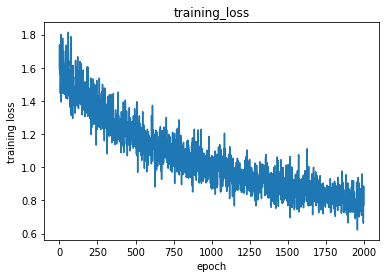

In [80]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.title.set_text("training_loss")
axis.set_xlabel("epoch")
axis.set_ylabel("training loss")
axis.plot(np.array(x_axis), np.array(y_loss))

In [88]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

(10, 200, 200, 3) (10, 200, 200, 3)


In [89]:
def restore_original_image_from_array(x, data_format=None):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


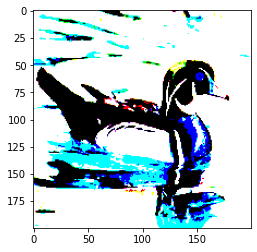

In [90]:
plt.imshow(A[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


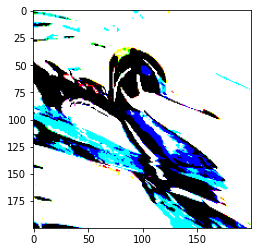

In [91]:
plt.imshow(B[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


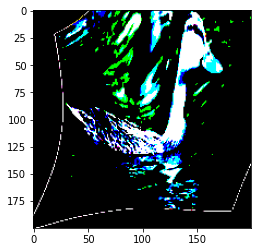

In [92]:
plt.imshow(warping_images[4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


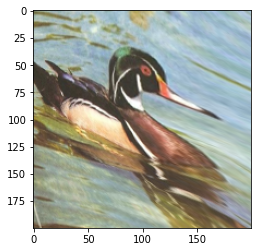

In [93]:
plt.imshow(restore_original_image_from_array(B[1].numpy())/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


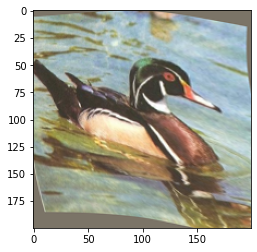

In [94]:
plt.imshow(restore_original_image_from_array(warping_images[1])/255)

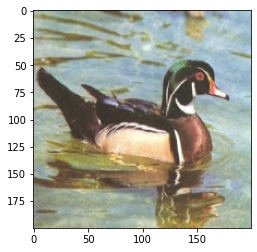

In [95]:
plt.imshow(images[1]/255)

# Comparison between ground-truth and prediction of motion vectors.

In [96]:
print(p.shape)
print(preds.shape)

(10, 9, 2)
(10, 9, 2)


In [135]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

(10, 200, 200, 3) (10, 200, 200, 3)


In [136]:
from dev_utils import draw
def decode(x):
    x = (x + 1)/2
    if type(x) != np.ndarray:
        return x.numpy()
    else:
        return x
def makeBorder(image, bordersize):
    draw_image = image.copy()
    color = [1, 1, 1]
    draw_image = cv2.copyMakeBorder(draw_image,
                                    top=bordersize, bottom=bordersize,
                                    left=bordersize, right=bordersize,
                                    borderType=cv2.BORDER_CONSTANT,
                                    value=color)
    return draw_image


def draw_point(image, bordersize, points=None):
    draw_image = image.copy()
    H, W, C = draw_image.shape
    if points is None:
        points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                           [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                           [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
    points = points * (W - 2 * bordersize, H - 2 * bordersize)
    points = points.astype(np.int32)
    for pnt in points:
        draw_image = cv2.circle(draw_image, tuple(
            pnt + bordersize), 1, (0, 1, 0), -1)
    return draw_image


def draw_arrow(image, bordersize, motion_parameters, src_points=None):
    draw_image = image.copy()
    H, W, C = image.shape
    if src_points is None:
        src_points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                               [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                               [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
    src_points = src_points * (W - 2 * bordersize, H - 2 * bordersize)
    src_points = src_points.astype(np.int32)
    motion_parameters = motion_parameters * \
        (W - 2 * bordersize, H - 2 * bordersize)
    dst_points = src_points + motion_parameters
    dst_points = dst_points.astype(np.int32)

    for src, dst in zip(src_points, dst_points):
        draw_image = cv2.arrowedLine(draw_image, tuple(src + bordersize), tuple(dst + bordersize),
                                     (1, 0, 0), 1)
    return draw_image

In [137]:
motion_vector = p[0].numpy()

padd = 50
white_board = makeBorder(A[0].numpy(), padd)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


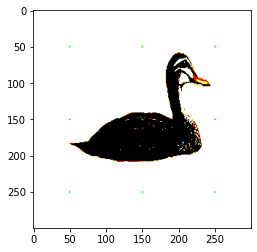

In [138]:
plt.imshow(draw_point(white_board, padd))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


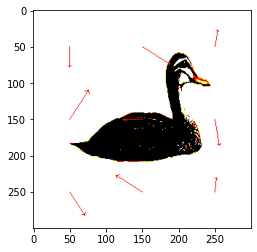

In [139]:
plt.imshow(draw_arrow(white_board, padd, p[0].numpy()/2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


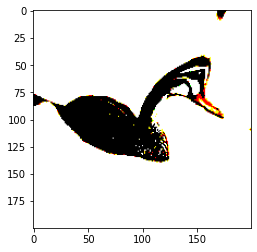

In [140]:
plt.imshow(B[0].numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


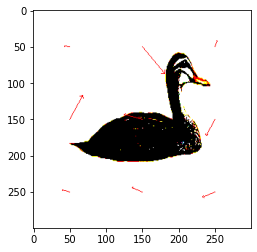

In [141]:
plt.imshow(draw_arrow(white_board, padd, preds[0].numpy()/2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


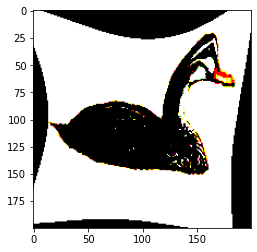

In [142]:
plt.imshow(warping_images[0])